# Gradient Boosting with XGBoost



We illustrate the following regression method on a data set called "Hitters", which includes 20 variables and 322 observations of major league baseball players. The goal is to predict a baseball player’s salary on the basis of various features associated with performance in the previous year. We don't cover the topic of exploratory data analysis in this notebook. 

- Visit [this documentation](https://cran.r-project.org/web/packages/ISLR/ISLR.pdf) if you want to learn more about the data

## Setup

In [1]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
print("XGB Version:", xgb.__version__)

from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

XGB Version: 1.6.0


## Data

- See [](hitters_data.ipynb) for details about the data preprocessing steps.
- We simply import the preprocessed data by using this [Python script](https://github.com/kirenz/regression/blob/main/docs/hitters_data.py) which will yield:
  - X_train, X_test, y_train, y_test
  - df_train and df_tests
  - feature_names

In [2]:
from hitters_data import *

## Model

- Define hyperparameters

In [3]:
params = {
    "n_estimators":50,
    "max_depth": 4,
    "learning_rate": 0.01,
    "eval_metric": "rmse"
}

- Prepare evaluation data

In [4]:
eval_set = [(X_train, y_train), (X_test, y_test)]

- Build and fit model

In [5]:
reg = xgb.XGBRegressor(**params)

reg.fit(X_train, y_train, eval_set=eval_set)

[0]	validation_0-rmse:693.13939	validation_1-rmse:694.51649
[1]	validation_0-rmse:687.25191	validation_1-rmse:688.37644
[2]	validation_0-rmse:681.42445	validation_1-rmse:682.31515
[3]	validation_0-rmse:675.64867	validation_1-rmse:677.35826
[4]	validation_0-rmse:669.93320	validation_1-rmse:672.46290
[5]	validation_0-rmse:664.27350	validation_1-rmse:666.60591
[6]	validation_0-rmse:658.67121	validation_1-rmse:661.82838
[7]	validation_0-rmse:653.12688	validation_1-rmse:656.90319
[8]	validation_0-rmse:647.63961	validation_1-rmse:652.24138
[9]	validation_0-rmse:642.19390	validation_1-rmse:646.64970
[10]	validation_0-rmse:636.80992	validation_1-rmse:641.92285
[11]	validation_0-rmse:631.48134	validation_1-rmse:637.27762
[12]	validation_0-rmse:626.19614	validation_1-rmse:631.90670
[13]	validation_0-rmse:620.97255	validation_1-rmse:627.37414
[14]	validation_0-rmse:615.80413	validation_1-rmse:622.82286
[15]	validation_0-rmse:610.68529	validation_1-rmse:618.45032
[16]	validation_0-rmse:605.60407	v

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

- Make predictions

In [6]:
y_pred = reg.predict(X_test)

- Obtain RMSE

In [7]:
mean_squared_error(y_test, y_pred, squared = False)

494.61957203317934

- Save te model

In [8]:
# Save model into JSON format.
reg.save_model("regressor.json")

### Plot training test deviance


- Obtain evaluation metrics

In [9]:
results = reg.evals_result()

- Plot training test deviance

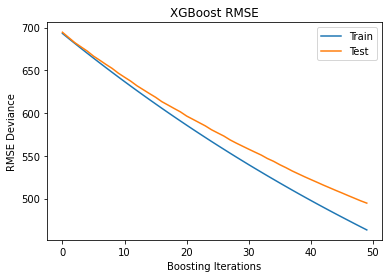

In [10]:
# Prepare x-axis
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()

ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')

plt.title('XGBoost RMSE')
plt.xlabel("Boosting Iterations")
plt.ylabel("RMSE Deviance")
plt.legend(loc="upper right");


## Feature importance

- Next, we take a look at the tree based feature importance and the permutation importance.

### Mean decrease in impurity (MDI)

- Mean decrease in impurity (MDI) is a measure of feature importance for decision tree models. 

```{Note}
Visit [this notebook](https://kirenz.github.io/feature-engineering/docs/mdi.html#) to learn more about MDI
```

- Feature importances are provided by the function `plot_importance` 

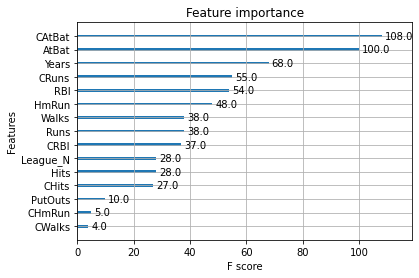

In [11]:
xgb.plot_importance(reg);

### Permutation feature importance

The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. 

```{Note}
Visit [this notebook](https://kirenz.github.io/feature-engineering/docs/permutation-feature-importance.html) to learn more about permutation feature importance.
```

In [12]:

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

In [13]:
feature_names

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors', 'League_N', 'Division_W', 'NewLeague_N'],
      dtype='object')

In [14]:
tree_importances = pd.Series(result.importances_mean, index=feature_names)

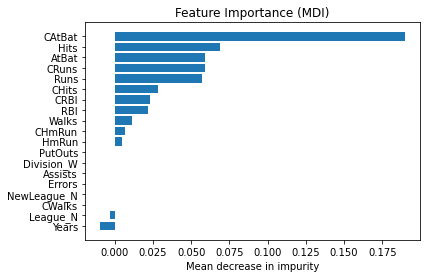

In [15]:
# sort features according to importance
sorted_idx = np.argsort(tree_importances)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, tree_importances[sorted_idx], align="center")

plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");

- Same data plotted as boxplot:

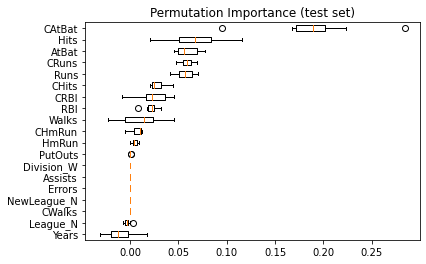

In [16]:
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names)[sorted_idx],
)

plt.title("Permutation Importance (test set)")
plt.show()

- We observe that the same features are detected as most important using both methods. Although the relative importances vary (especially for feature `Years`).